<a href="https://colab.research.google.com/github/MaxRong/Trade-Prediction-Model-UCSB-DataOrbit-2025/blob/main/Datathon_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
# Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns





In [1]:
# Import data
match_info = pd.read_csv('/content/European Soccer Dataset/MATCH.csv').drop_duplicates()
player_info = pd.read_csv('/content/European Soccer Dataset/PLAYER.csv').drop_duplicates()
player_attr = pd.read_csv('/content/European Soccer Dataset/PLAYER_ATTRIBUTES.csv').drop_duplicates()
team_info = pd.read_csv('/content/European Soccer Dataset/TEAM.csv').drop_duplicates()
team_attr = pd.read_csv('/content/European Soccer Dataset/TEAM_ATTRIBUTES.csv').drop_duplicates()




NameError: name 'pd' is not defined

# Data Cleaning/Preprocessing

### Aggregate Player Team Data by Season


In [ ]:
# Create lists of player column names
home_cols = [f'home_player_{i}' for i in range(1, 12)]
away_cols = [f'away_player_{i}' for i in range(1, 12)]

# Create id_vars for each set
home_id_vars = ['season', 'home_team_api_id', 'date']
away_id_vars = ['season', 'away_team_api_id', 'date']

# Select the relevant columns for home and away players
df_home = match_info[home_cols + home_id_vars]
df_away = match_info[away_cols + away_id_vars]

# Melt home df from wide to long.
df_home = df_home.melt(id_vars=home_id_vars,
                       value_vars=home_cols,
                       var_name='player_num',
                       value_name='player')

# Rename the team column to a common name 'team'
df_home = df_home.rename(columns={'home_team_api_id': 'team'})

# Melt away df from wide to long and rename
df_away = df_away.melt(id_vars=away_id_vars,
                       value_vars=away_cols,
                       var_name='player_num',
                       value_name='player')
df_away = df_away.rename(columns={'away_team_api_id': 'team'})

# Stack home and away player team data into one dataframe
player_team_df = pd.concat([df_home, df_away], ignore_index=True)

# Drop null values and remove unneeded columns
player_team_df = player_team_df.dropna()
player_team_df.drop('player_num', axis=1, inplace=True)

<ipython-input-121-881cc1d08aa2>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_team_df.drop('player_num', axis=1, inplace=True)


In [ ]:


# view combined
player_team_df.head()

,season,team,date,player
144,2008/2009,9996,2009-02-28 00:00:00,39890.0
145,2008/2009,8203,2009-02-27 00:00:00,38327.0
146,2008/2009,9986,2009-02-28 00:00:00,95597.0
148,2008/2009,9994,2009-03-01 00:00:00,30934.0
149,2008/2009,8342,2009-02-28 00:00:00,37990.0


### Use player Team History to understand Trade History

> Add blockquote




In [ ]:
# Build player team history dictionary
player_dict = {}
for player in player_team_df['player'].unique():
    subset = player_team_df[player_team_df['player'] == player]
    # Get unique (season, team, date) tuples as a list of tuples
    pairs = subset[['season', 'team']].drop_duplicates().to_records(index=False)
    player_dict[player] = list(pairs)

In [ ]:
# Using player team history dictionary, check if a trade occurred
records = []
for player, history in player_dict.items():
    # update initial team allegiance
    curr = (history[0][1])
    for season, team in history:
        if team == curr:
            traded = False
        else:
            traded = True
            curr = team
        # append 'traded' value to list
        records.append({
            'playerid': player,
            'season': season,
            'teamid': team,
            'traded': traded
        })

# convert records to player dataframe
player_history_df = pd.DataFrame(records)
player_history_df.head(20)

,playerid,season,teamid,traded
0,39890.0,2008/2009,9996,False
1,39890.0,2010/2011,9997,True
2,38327.0,2008/2009,8203,False
3,38327.0,2009/2010,8203,False
4,38327.0,2011/2012,8203,False
5,38327.0,2012/2013,8203,False
6,38327.0,2014/2015,8203,False
7,38327.0,2015/2016,8573,True
8,95597.0,2008/2009,9986,False
9,95597.0,2011/2012,4087,True


### Cleaning/Organizing Player Attributes Data by Season and Player

In [ ]:
# create player statistics dataframe
player_stats_df = player_attr[['player_api_id','date','overall_rating', \
                               'potential', 'finishing', 'dribbling', \
                               'short_passing','acceleration', \
                               'sprint_speed', 'stamina', 'strength' , \
                               'attacking_work_rate', 'defensive_work_rate', \
                               'positioning', 'reactions', 'vision']]

# A season begins in
player_stats_df['season'] = pd.to_datetime(player_stats_df['date']). \
  apply(lambda x: f"{x.year}/{x.year+1}" if x.month >= 8 else f"{x.year-1}/{x.year}")

player_stats_df.rename(columns={'player_api_id': 'playerid'}, inplace=True)

<ipython-input-125-3fc5dc93ac4e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_stats_df['season'] = pd.to_datetime(player_stats_df['date']). \
<ipython-input-125-3fc5dc93ac4e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_stats_df.rename(columns={'player_api_id': 'playerid'}, inplace=True)


In [ ]:

# Ensure birthday and match dates are datetime format
player_info['birthday'] = pd.to_datetime(player_info['birthday'])
player_stats_df['date'] = pd.to_datetime(player_stats_df['date'])

# Remove duplicate player IDs from player_info, keeping the first unique birthday
player_info_clean = player_info.sort_values(by=['player_api_id', 'birthday']).drop_duplicates(subset='player_api_id', keep='first')

player_info_clean.rename(columns={'player_api_id': 'playerid'}, inplace=True)

# Merge safely (each player keeps their original multiple game entries)
player_stats_df = player_stats_df.merge(player_info_clean, on='playerid', how='left')

# Calculate age correctly for each game entry
player_stats_df['age'] = player_stats_df.apply(
    lambda x: x['date'].year - x['birthday'].year -
              ((x['date'].month, x['date'].day) < (x['birthday'].month, x['birthday'].day)),
    axis=1
)


<ipython-input-126-fced5111d02e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_stats_df['date'] = pd.to_datetime(player_stats_df['date'])


In [ ]:
# Drop columns that are no longer needed
player_stats_df.drop(['birthday', 'player_name', 'player_fifa_api_id', 'height', 'weight', 'age'], axis=1, inplace=True)


In [ ]:
player_stats_df.head(20)


,playerid,date,overall_rating,potential,finishing,dribbling,short_passing,acceleration,sprint_speed,stamina,strength,attacking_work_rate,defensive_work_rate,positioning,reactions,vision,season,id
0,505942,2016-02-18,67.0,71.0,44.0,51.0,61.0,60.0,64.0,54.0,76.0,medium,medium,45.0,47.0,54.0,2015/2016,1
1,505942,2015-11-19,67.0,71.0,44.0,51.0,61.0,60.0,64.0,54.0,76.0,medium,medium,45.0,47.0,54.0,2015/2016,1
2,505942,2015-09-21,62.0,66.0,44.0,51.0,61.0,60.0,64.0,54.0,76.0,medium,medium,45.0,47.0,54.0,2015/2016,1
3,505942,2015-03-20,61.0,65.0,43.0,50.0,60.0,60.0,64.0,54.0,76.0,medium,medium,44.0,46.0,53.0,2014/2015,1
4,505942,2007-02-22,61.0,65.0,43.0,50.0,60.0,60.0,64.0,54.0,76.0,medium,medium,44.0,46.0,53.0,2006/2007,1
5,155782,2016-04-21,74.0,76.0,53.0,73.0,71.0,79.0,78.0,79.0,56.0,high,medium,60.0,67.0,66.0,2015/2016,2
6,155782,2016-04-07,74.0,76.0,53.0,73.0,71.0,79.0,78.0,79.0,56.0,high,medium,60.0,67.0,66.0,2015/2016,2
7,155782,2016-01-07,73.0,75.0,52.0,71.0,70.0,79.0,78.0,79.0,56.0,high,medium,58.0,67.0,65.0,2015/2016,2
8,155782,2015-12-24,73.0,75.0,51.0,71.0,70.0,79.0,78.0,79.0,56.0,high,medium,58.0,67.0,65.0,2015/2016,2
9,155782,2015-12-17,73.0,75.0,51.0,71.0,70.0,79.0,78.0,79.0,56.0,high,medium,58.0,67.0,65.0,2015/2016,2


### Cleaning/Organizing Team Data by Season and Calculating Winrate

In [ ]:
# create initial match result dataframe


match_res = match_info[home_cols + away_cols + ['match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'season', 'date']]

match_res['result'] = np.select(
    [
        match_res['home_team_goal'] > match_res['away_team_goal'],  # Home Team Win
        match_res['home_team_goal'] < match_res['away_team_goal'],  # Away Team Win
    ],
    [
        1, # Home Team Win
        0, # Home Team Win
    ],
    default = 0.5  # Draw if scores are equal
)


<ipython-input-129-0522a4225525>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_res['result'] = np.select(


In [ ]:

# Calculate team winrates by season

winrates = []

# Get select all game data for each team
for team in team_info['team_api_id'].unique():
    subset = match_res[(match_res['home_team_api_id'] == team) | (match_res['away_team_api_id'] == team)]
    # calculate winrates by season
    for season in subset['season'].unique():
        season_subset = subset[subset['season'] == season].copy()

        # Adjust results based on whether the team is home or away
        season_subset['adjusted_result'] = season_subset.copy().apply(
            lambda row: row['result'] if row['home_team_api_id'] == team else 1 - row['result'],
            axis=1
        )

        winrate = season_subset['adjusted_result'].mean()  # Calculate mean win rate

        winrates.append({
            'teamid': team,
            'season': season,
            'team winrate': winrate
        })
# Convert team winrate by season to DataFrame
team_wr_df = pd.DataFrame(winrates)
print(team_wr_df.sort_values(by='team winrate'))

     teamid     season  team winrate
30     9984  2012/2013      0.183333
182   10252  2015/2016      0.184211
395  108893  2010/2011      0.223684
20     9994  2009/2010      0.232143
47     9998  2008/2009      0.235294
..      ...        ...           ...
336    9847  2013/2014      0.815789
384    9853  2014/2015      0.821429
318    9748  2014/2015      0.821429
112    8573  2013/2014      0.833333
33     8635  2009/2010      0.839286

[417 rows x 3 columns]


# Feature Engineering

In [ ]:
# Merge our dataframes together
player_trade_stats_df = pd.merge(pd.merge(player_history_df, team_wr_df,on=['teamid', 'season'], how='inner'), player_stats_df, on=['playerid', 'season'], how='inner')
player_trade_stats_df.dropna(inplace=True)

# drop unique identifier columns & seasons since no longer necessary
player_trade_stats_df.drop(['playerid', 'teamid', 'season'], axis=1, inplace=True)

# convert categorical data into indicator variables
player_trade_stats = pd.get_dummies(player_trade_stats_df, columns=['attacking_work_rate', 'defensive_work_rate'], drop_first=True)

# Difference between a player’s potential and current rating might be a factor in trades
player_trade_stats_df['potential_gap'] = player_trade_stats_df['potential'] - player_trade_stats_df['overall_rating']


In [ ]:
player_trade_stats_df.head(50)

,traded,team winrate,date,overall_rating,potential,finishing,dribbling,short_passing,acceleration,sprint_speed,stamina,strength,attacking_work_rate,defensive_work_rate,positioning,reactions,vision,id,potential_gap
0,False,0.470588,2009-02-22,66.0,68.0,20.0,22.0,46.0,53.0,48.0,66.0,70.0,medium,medium,13.0,67.0,68.0,6893,2.0
1,False,0.470588,2008-08-30,64.0,69.0,25.0,32.0,33.0,42.0,45.0,71.0,70.0,medium,medium,35.0,55.0,68.0,6893,5.0
2,True,0.350000,2011-02-22,66.0,69.0,15.0,22.0,31.0,58.0,56.0,51.0,71.0,medium,medium,18.0,67.0,35.0,6893,3.0
3,True,0.350000,2010-08-30,68.0,69.0,15.0,22.0,46.0,61.0,58.0,56.0,73.0,medium,medium,18.0,67.0,68.0,6893,1.0
4,False,0.500000,2008-08-30,58.0,67.0,25.0,25.0,25.0,45.0,41.0,40.0,73.0,medium,medium,33.0,57.0,50.0,10846,9.0
5,False,0.482143,2010-02-22,62.0,67.0,25.0,25.0,25.0,45.0,41.0,40.0,73.0,medium,medium,33.0,62.0,50.0,10846,5.0
6,False,0.482143,2009-08-30,61.0,67.0,25.0,25.0,25.0,45.0,41.0,40.0,73.0,medium,medium,33.0,62.0,50.0,10846,6.0
7,False,0.450000,2012-02-22,64.0,65.0,11.0,10.0,11.0,45.0,41.0,40.0,73.0,medium,medium,11.0,62.0,31.0,10846,1.0
8,False,0.450000,2011-08-30,64.0,65.0,11.0,10.0,11.0,45.0,41.0,40.0,73.0,medium,medium,11.0,62.0,31.0,10846,1.0
9,False,0.483333,2012-08-31,64.0,65.0,11.0,10.0,11.0,45.0,41.0,30.0,73.0,medium,medium,11.0,62.0,31.0,10846,1.0


# Model Training

### Data Evaluation
Notes:
1. Not severe class imbalance, but recall may be low. Handle with scale_pos_weight
2. Need to numericalize categorical data(attacking_work_rate, etc)

In [ ]:
# Evaluating dataset
print(player_trade_stats_df[player_trade_stats['traded']==False].shape, \
      player_trade_stats_df[player_trade_stats['traded']].shape)

# 10656:2757 True:False, not severe class imbalance, but Recall may be low

player_trade_stats_df.drop('date', axis=1, inplace=True)
player_trade_stats_df.drop_duplicates()
player_trade_stats_df = player_trade_stats_df.drop(columns=['id'])
player_trade_stats_df.head()




(22065, 19) (6416, 19)


,traded,team winrate,overall_rating,potential,finishing,dribbling,short_passing,acceleration,sprint_speed,stamina,strength,attacking_work_rate,defensive_work_rate,positioning,reactions,vision,potential_gap
0,False,0.470588,66.0,68.0,20.0,22.0,46.0,53.0,48.0,66.0,70.0,medium,medium,13.0,67.0,68.0,2.0
1,False,0.470588,64.0,69.0,25.0,32.0,33.0,42.0,45.0,71.0,70.0,medium,medium,35.0,55.0,68.0,5.0
2,True,0.350000,66.0,69.0,15.0,22.0,31.0,58.0,56.0,51.0,71.0,medium,medium,18.0,67.0,35.0,3.0
3,True,0.350000,68.0,69.0,15.0,22.0,46.0,61.0,58.0,56.0,73.0,medium,medium,18.0,67.0,68.0,1.0
4,False,0.500000,58.0,67.0,25.0,25.0,25.0,45.0,41.0,40.0,73.0,medium,medium,33.0,57.0,50.0,9.0


In [ ]:
# Dummy data
player_trade_stats_df = pd.get_dummies(player_trade_stats_df, columns=['attacking_work_rate', 'defensive_work_rate'], drop_first=True)
player_trade_stats.head()


,traded,team winrate,date,overall_rating,potential,finishing,dribbling,short_passing,acceleration,sprint_speed,...,defensive_work_rate_2,defensive_work_rate_3,defensive_work_rate_4,defensive_work_rate_ean,defensive_work_rate_es,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,defensive_work_rate_ormal,defensive_work_rate_tocky
0,False,0.470588,2009-02-22,66.0,68.0,20.0,22.0,46.0,53.0,48.0,...,False,False,False,False,False,False,False,True,False,False
1,False,0.470588,2008-08-30,64.0,69.0,25.0,32.0,33.0,42.0,45.0,...,False,False,False,False,False,False,False,True,False,False
2,True,0.350000,2011-02-22,66.0,69.0,15.0,22.0,31.0,58.0,56.0,...,False,False,False,False,False,False,False,True,False,False
3,True,0.350000,2010-08-30,68.0,69.0,15.0,22.0,46.0,61.0,58.0,...,False,False,False,False,False,False,False,True,False,False
4,False,0.500000,2008-08-30,58.0,67.0,25.0,25.0,25.0,45.0,41.0,...,False,False,False,False,False,False,False,True,False,False


In [ ]:
# Split data into train and test
X = player_trade_stats_df.drop('traded', axis=1)
y = player_trade_stats_df['traded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


### Training XGBoost Model


In [ ]:
# Calculate scale_pos_weight
traded_count = sum(y_train == 1)
not_traded_count = sum(y_train == 0)
scale_pos_weight = not_traded_count / traded_count  # Adjusts class balance

In [ ]:
# Model Training
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.9, 1],
    'colsample_bytree': [0.7, 0.9, 1]
}

# Initialize the XGBoost classifier with GPU acceleration
model = xgb.XGBClassifier(
    tree_method='gpu_hist',   # Use GPU-based histogram algorithm
    use_label_encoder=False,
    eval_metric='logloss',    # Use logloss as evaluation metric
    random_state=42
)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',
    cv=3,           # 3-fold cross-validation
    verbose=2,
    n_jobs=-1       # Use all available CPU cores for parallel processing
)

# Fit GridSearchCV on your training data
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 243 candidates, totalling 729 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:33:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:33:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.7}


In [ ]:
# Show best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.7}
Best Score: 0.741869988853403


In [ ]:
# Evaluate the performance
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)


# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Print a detailed classification report
print(classification_report(y_test, y_pred))

Test Accuracy: 0.9146919431279621
              precision    recall  f1-score   support

       False       0.92      0.98      0.95      4414
        True       0.89      0.71      0.79      1283

    accuracy                           0.91      5697
   macro avg       0.91      0.84      0.87      5697
weighted avg       0.91      0.91      0.91      5697



In [ ]:
# serialize model to JSON
best_model.save_model("model_up.json")



In [ ]:
# save data to csv
player_trade_stats_df.to_csv('player_trade_stats.csv', index=False)


# Data Visualization


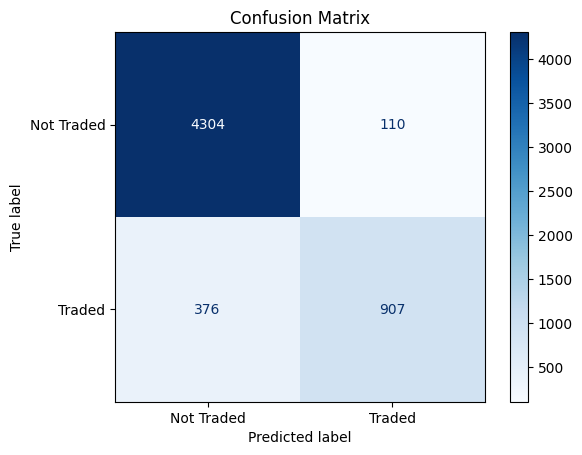

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Traded", "Traded"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

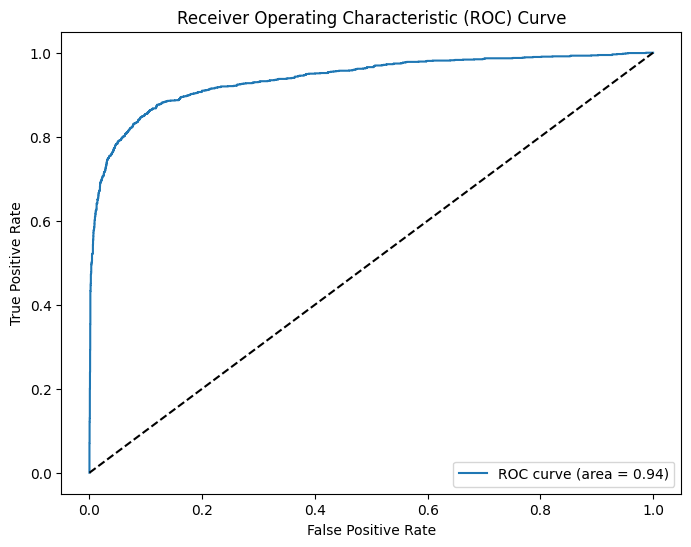

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
# Roc Curve

y_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


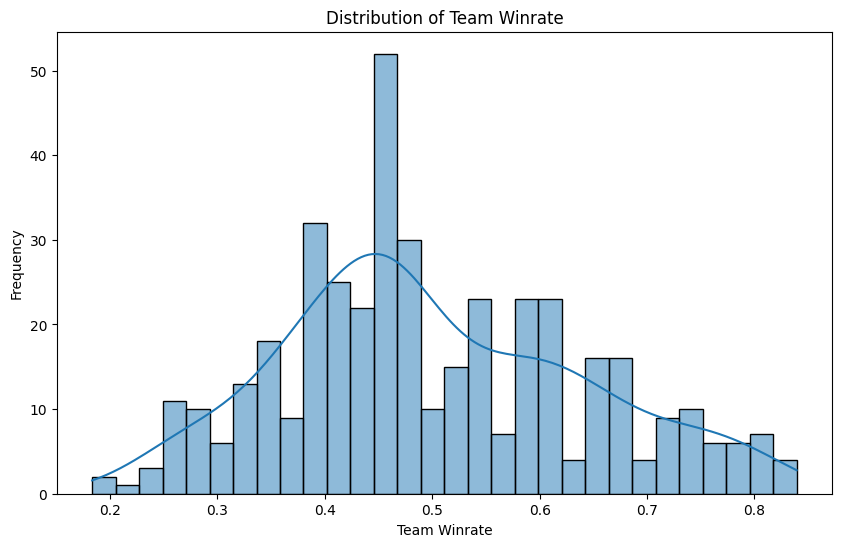

In [ ]:

# Team Winrates
plt.figure(figsize=(10, 6))
sns.histplot(team_wr_df['team winrate'], kde=True, bins=30)
plt.title("Distribution of Team Winrate")
plt.xlabel("Team Winrate")
plt.ylabel("Frequency")
plt.show()


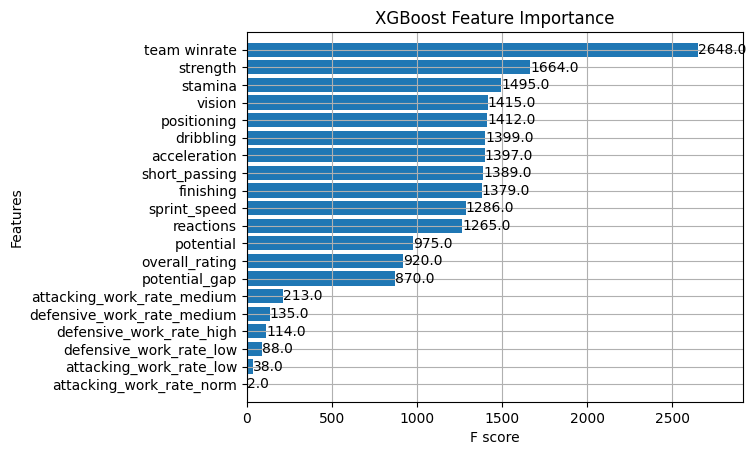

In [ ]:
# Plot feature importance
xgb.plot_importance(best_model, max_num_features=20, height=0.8)
plt.title("XGBoost Feature Importance")
plt.show()